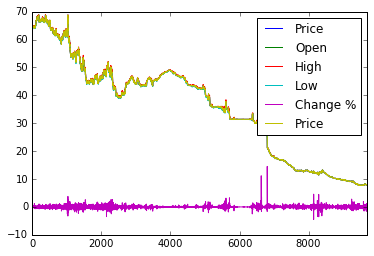

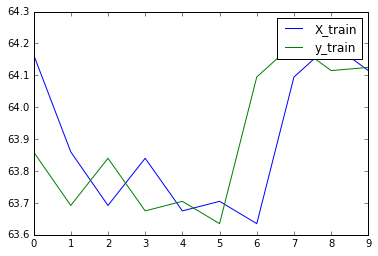

In [21]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# # Plotting the smartwatch data before scaling/batch normalization
data[:10000].plot() #x='dteday', y='cnt'

# data[:100].plot()
np.array(data).shape, np.array(data).dtype, np.array(data, dtype=None).dtype, 
# np.array(data[:, 1:], dtype=None).dtype

data = np.array(data)
plt.plot(data[:10000, 1], label='Price')
# plt.plot(data[:1000, 2], label='Open')
plt.legend()
plt.show()

# Sequence learning - seq2seq learning - Unsupervised Learning
# Training
X_train = np.array(data[0:-2, 1], dtype=float).reshape(-1, 1)
y_train = np.array(data[1:-1, 1], dtype=float).reshape(-1, 1)
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

# # type(X_train[2, 1])
# # X_train.shape
# np.array(X_train).dtype, np.array(X_train, dtype=None).dtype, np.array(X_train, dtype=float).dtype

plt.plot(X_train[:10], label='X_train')
plt.plot(y_train[:10], label='y_train')
plt.legend()
plt.show()

In [22]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L): #, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
#         self.idx2char = idx2char
#         self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
#             X_one_hot = np.zeros(self.D)
#             X_one_hot[X] = 1.
#             print('X.shape', X.shape)
            X = X.reshape(1, -1)
#             print('X.shape', X.shape)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches
    
    def loss_function(self, y_pred, y_train):
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression(y_pred=y, y_train=Y) #/ m: t or number of samples for taking the average
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
                
        return grads
    
    def test(self, X_seed, h, size):
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
            ys.append(y)
            
        return ys

In [23]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
#     for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            # def loss_function(self, y_pred, y_train):
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini)
            grads = nn.train_backward(dys, caches)
            
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Validation loss to avoid overfitting & underfitting
        mb_num = len(minibatches) //2
        X_test, _ = minibatches[mb_num]
        ys = nn.test(X_seed= X_test[0], size=100, h= state)
        valid_loss, _ = nn.loss_function(y_pred=ys, y_train=y_mini)
            
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.4f}, valid loss: {:.4f}'.format(iter, loss, valid_loss))
#             sample = nn.test(X_mini[0], state, 200)
#             print(sample)

    return nn

Iter-1 loss: 181.3814
Iter-2 loss: 55.5510
Iter-3 loss: 368.7907
Iter-4 loss: 781.5212
Iter-5 loss: 1218.2114
Iter-6 loss: 1638.2915
Iter-7 loss: 1980.3015
Iter-8 loss: 2136.7734
Iter-9 loss: 2086.0018
Iter-10 loss: 1976.2874
Iter-11 loss: 1836.6447
Iter-12 loss: 1650.9192
Iter-13 loss: 1434.1526
Iter-14 loss: 1191.7595
Iter-15 loss: 921.9501
Iter-16 loss: 641.6691
Iter-17 loss: 393.1263
Iter-18 loss: 216.7464
Iter-19 loss: 118.9529
Iter-20 loss: 76.9892
Iter-21 loss: 61.6380
Iter-22 loss: 55.2561
Iter-23 loss: 52.4205
Iter-24 loss: 51.8965
Iter-25 loss: 52.3440
Iter-26 loss: 52.7773
Iter-27 loss: 52.8374
Iter-28 loss: 52.8327
Iter-29 loss: 52.8972
Iter-30 loss: 52.9329
Iter-31 loss: 52.9314
Iter-32 loss: 52.8966
Iter-33 loss: 52.7985
Iter-34 loss: 52.6384
Iter-35 loss: 52.4247
Iter-36 loss: 52.1642
Iter-37 loss: 51.8658
Iter-38 loss: 51.5158
Iter-39 loss: 51.1036
Iter-40 loss: 50.6638
Iter-41 loss: 50.2458
Iter-42 loss: 49.8948
Iter-43 loss: 49.6169
Iter-44 loss: 49.4943
Iter-45 loss:

Iter-368 loss: 2.7053
Iter-369 loss: 3.1496
Iter-370 loss: 2.7978
Iter-371 loss: 3.4099
Iter-372 loss: 2.8301
Iter-373 loss: 2.7300
Iter-374 loss: 3.1083
Iter-375 loss: 3.0914
Iter-376 loss: 3.6297
Iter-377 loss: 3.5138
Iter-378 loss: 3.1110
Iter-379 loss: 11.4578
Iter-380 loss: 19.2535
Iter-381 loss: 6.8108
Iter-382 loss: 3.2563
Iter-383 loss: 4.3874
Iter-384 loss: 4.9020
Iter-385 loss: 5.4543
Iter-386 loss: 3.7274
Iter-387 loss: 4.1309
Iter-388 loss: 3.2548
Iter-389 loss: 3.7288
Iter-390 loss: 3.3165
Iter-391 loss: 3.8787
Iter-392 loss: 3.3885
Iter-393 loss: 3.9452
Iter-394 loss: 3.6581
Iter-395 loss: 4.2569
Iter-396 loss: 4.1470
Iter-397 loss: 4.4159
Iter-398 loss: 4.3413
Iter-399 loss: 3.8986
Iter-400 loss: 3.6592
Iter-401 loss: 3.1426
Iter-402 loss: 3.7462
Iter-403 loss: 4.3493
Iter-404 loss: 5.8470
Iter-405 loss: 6.2009
Iter-406 loss: 3.1973
Iter-407 loss: 5.5812
Iter-408 loss: 12.0636
Iter-409 loss: 12.3827
Iter-410 loss: 4.8187
Iter-411 loss: 4.6503
Iter-412 loss: 4.1734
Iter-4

Iter-740 loss: 5.1163
Iter-741 loss: 2.9540
Iter-742 loss: 2.4291
Iter-743 loss: 2.4509
Iter-744 loss: 3.1074
Iter-745 loss: 2.8172
Iter-746 loss: 2.6838
Iter-747 loss: 2.2741
Iter-748 loss: 2.2163
Iter-749 loss: 1.8548
Iter-750 loss: 1.8028
Iter-751 loss: 1.4004
Iter-752 loss: 1.3529
Iter-753 loss: 1.3968
Iter-754 loss: 1.3837
Iter-755 loss: 1.4396
Iter-756 loss: 1.3768
Iter-757 loss: 1.6383
Iter-758 loss: 2.5182
Iter-759 loss: 1.8156
Iter-760 loss: 1.7579
Iter-761 loss: 7.0612
Iter-762 loss: 14.3503
Iter-763 loss: 4.4510
Iter-764 loss: 2.6596
Iter-765 loss: 2.6500
Iter-766 loss: 3.1991
Iter-767 loss: 3.6870
Iter-768 loss: 3.2029
Iter-769 loss: 2.9025
Iter-770 loss: 2.7703
Iter-771 loss: 2.9308
Iter-772 loss: 2.8332
Iter-773 loss: 2.9068
Iter-774 loss: 2.6504
Iter-775 loss: 2.7812
Iter-776 loss: 2.5855
Iter-777 loss: 2.7515
Iter-778 loss: 2.4900
Iter-779 loss: 2.6005
Iter-780 loss: 2.2955
Iter-781 loss: 2.3572
Iter-782 loss: 1.9672
Iter-783 loss: 1.9543
Iter-784 loss: 1.4976
Iter-785 

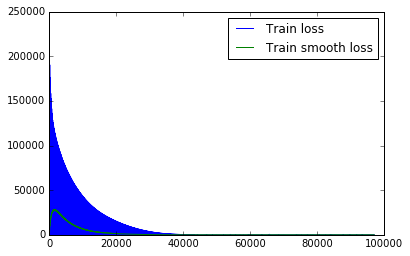

In [25]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = 1 #len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers) #, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X_train, y_train=y_train, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()